In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import scale,normalize
from sklearn import preprocessing
from scipy.stats import pearsonr , spearmanr
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [2]:
df = pd.read_csv(r"C:\Users\siavash\Documents\Projects\Bank_Churn.csv")
print(df.head())
print(df.isnull().sum())
print(df.shape)

   CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure  \
0    15634602  Hargrave          619    France  Female   42       2   
1    15647311      Hill          608     Spain  Female   41       1   
2    15619304      Onio          502    France  Female   42       8   
3    15701354      Boni          699    France  Female   39       1   
4    15737888  Mitchell          850     Spain  Female   43       2   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              1          1               1        101348.88   
1   83807.86              1          0               1        112542.58   
2  159660.80              3          1               0        113931.57   
3       0.00              2          0               0         93826.63   
4  125510.82              1          1               1         79084.10   

   Exited  
0       1  
1       0  
2       1  
3       0  
4       0  
CustomerId         0
Surname            0
CreditSc

In [3]:
#Drop ID‑like columns
df.drop(['CustomerId', 'Surname'], axis=1, inplace=True)
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
# Encode categorical variables
Data = df.drop('Exited', axis=1).values
Target = df['Exited'].values

LE = preprocessing.LabelEncoder()

LE.fit(['Female', 'Male'])
Data[:, 2] = LE.transform(Data[:, 2])

LE.fit(['France', 'Germany', 'Spain'])
Data[:, 1] = LE.transform(Data[:, 1])


In [5]:
# Scale features
Scale_Data = scale(Data)
print(Scale_Data[:5])

[[-0.32622142 -0.90188624 -1.09598752  0.29351742 -1.04175968 -1.22584767
  -0.91158349  0.64609167  0.97024255  0.02188649]
 [-0.44003595  1.51506738 -1.09598752  0.19816383 -1.38753759  0.11735002
  -0.91158349 -1.54776799  0.97024255  0.21653375]
 [-1.53679418 -0.90188624 -1.09598752  0.29351742  1.03290776  1.33305335
   2.52705662  0.64609167 -1.03067011  0.2406869 ]
 [ 0.50152063 -0.90188624 -1.09598752  0.00745665 -1.38753759 -1.22584767
   0.80773656 -1.54776799 -1.03067011 -0.10891792]
 [ 2.06388377  1.51506738 -1.09598752  0.38887101 -1.04175968  0.7857279
  -0.91158349  0.64609167  0.97024255 -0.36527578]]


In [6]:
# Simple correlation example (Spearman)
p_coeff, p_value = spearmanr(df['IsActiveMember'], df['Exited'])
print('p_coeff:', p_coeff, "p-value:", p_value)

p_coeff: -0.1561282781889051 p-value: 1.3482685164858006e-55


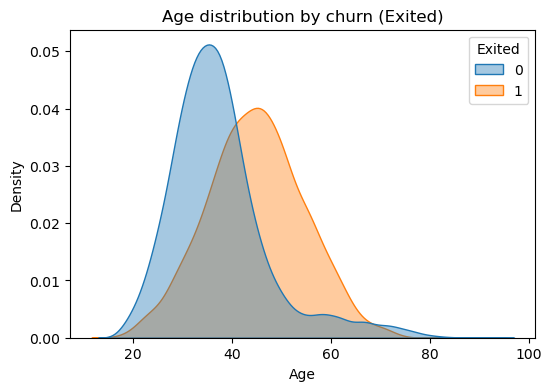

In [7]:
# 0 = stay, 1 = exit
plt.figure(figsize=(6,4))
sns.kdeplot(data=df, x="Age", hue="Exited",
            common_norm=False, fill=True, alpha=0.4)
plt.title("Age distribution by churn (Exited)")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show()

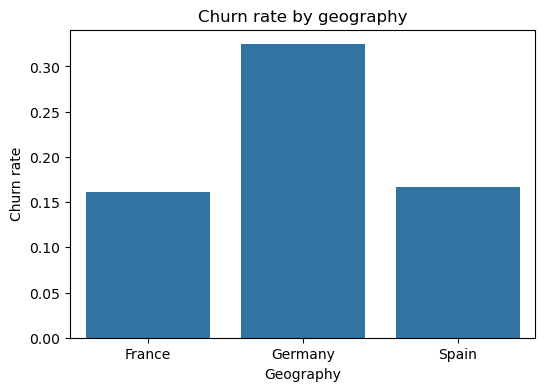

In [8]:
plt.figure(figsize=(6,4))
churn_geo = df.groupby("Geography")["Exited"].mean().reset_index()
sns.barplot(data=churn_geo, x="Geography", y="Exited")
plt.title("Churn rate by geography")
plt.ylabel("Churn rate")
plt.show()


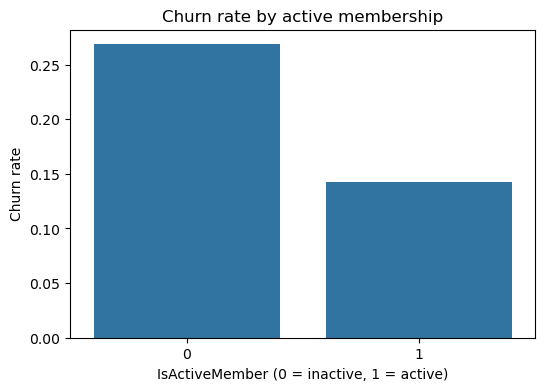

In [9]:
plt.figure(figsize=(6,4))
churn_active = df.groupby("IsActiveMember")["Exited"].mean().reset_index()
sns.barplot(data=churn_active, x="IsActiveMember", y="Exited")
plt.title("Churn rate by active membership")
plt.xlabel("IsActiveMember (0 = inactive, 1 = active)")
plt.ylabel("Churn rate")
plt.show()


In [10]:
# KNN with GridSearchCV
x_train, x_test, y_train, y_test = train_test_split(Data, Target, test_size=0.3, random_state=20)

p_grid = {'n_neighbors': np.arange(1, 40)}
knn = KNeighborsClassifier()
knn_cv = GridSearchCV(knn, p_grid, cv=5)
knn_cv.fit(Data, Target)

print("Best K:", knn_cv.best_params_)
print("Best CV score:", knn_cv.best_score_)

best_k = knn_cv.best_params_['n_neighbors']
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(x_train, y_train)

y_pred_knn = knn.predict(x_test)
mse_knn = mean_squared_error(y_pred_knn, y_test)
print("KNN MSE on test:", mse_knn)


Best K: {'n_neighbors': np.int64(24)}
Best CV score: 0.7964
KNN MSE on test: 0.195


In [11]:
# Decision tree on scaled data
x_trainset, x_testset, y_trainset, y_testset = train_test_split(
    Scale_Data, Target, test_size=0.2, random_state=42
)

bank_tree = DecisionTreeClassifier(criterion='entropy', max_depth=4)
bank_tree.fit(x_trainset, y_trainset)

Target_pred = bank_tree.predict(x_testset)
mse_tree = mean_squared_error(Target_pred, y_testset)
print("DecisionTree MSE on test:", mse_tree)

DecisionTree MSE on test: 0.146


In [12]:
# Predict for a new customer 
new_raw = np.array([[600, 'France', 'Male', 40, 5,
                     60000, 2, 1, 1, 50000]], dtype=object)

# use the same encoding logic as for Data
LE = preprocessing.LabelEncoder()

# Gender
Gender = ['Female', 'Male']
LE.fit(Gender)
new_raw[:, 2] = LE.transform(new_raw[:, 2])

# Geography 
Geography = ['France', 'Germany', 'Spain']
LE.fit(Geography)
new_raw[:, 1] = LE.transform(new_raw[:, 1])

# convert to float
new_raw = new_raw.astype(float)

# apply the same scaling as used for Scale_Data
data_mean = np.mean(Scale_Data, axis=0)
data_std  = np.std(Scale_Data, axis=0, ddof=0)
new_scaled = (new_raw - data_mean) / data_std

# predict with the already trained decision tree
prediction = bank_tree.predict(new_scaled)
print("New customer churn prediction (0=stay, 1=exit):", prediction[0])


New customer churn prediction (0=stay, 1=exit): 1
